In [11]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from config import cache_path, save_path
from pathlib import Path
import numpy as np

In [10]:
boc = BrainObservatoryCache(manifest_file=str(
            Path(cache_path) / 'brain_observatory_manifest.json'))

eid=501559087

data_dct={}

data_set = boc.get_ophys_experiment_data(eid)

data_dct['movie_stim_table'] = data_set.get_stimulus_table(
                'natural_movie_one')

data_dct['neural_responses'] = data_set.get_dff_traces()[1]

In [27]:
embeddings=np.load(Path(save_path)/Path('natural_movie_one_clip.npy'))
#embeddings=np.load(Path(save_path)/Path('movie_one.npy'))
print(embeddings.shape)

(900, 768)


In [15]:
def make_regression_data(data_dct, embeddings):
        np.random.seed = 7879
        train_movies = np.random.randint(0, 901)
        stimuli = data_dct['movie_stim_table'].loc[data_dct['movie_stim_table']['repeat'] == 2]
        test_movies = np.random.choice(range(900), 200, replace=False)
            # Generate an array containing all possible indices from 0 to 900 (inclusive)
        all_indices = np.arange(900)
            # Get the train indices as the complement of the test indices
        train_movies = np.setdiff1d(all_indices, test_movies)
        train_inds = stimuli.loc[stimuli['frame'].isin(
                train_movies), 'start'].values
        test_inds = stimuli.loc[stimuli['frame'].isin(
                test_movies), 'start'].values

        y_train_movie = data_dct['neural_responses'][:, train_inds]
        y_test_movie = data_dct['neural_responses'][:, test_inds]

        test_embedding=embeddings[test_movies,:]
        train_embedding=embeddings[train_movies,:]

        return y_test_movie, y_train_movie, test_embedding, train_embedding

y_test_movie, y_train_movie, test_embedding, train_embedding = make_regression_data(data_dct, embeddings) 

In [41]:
y_train_movie.shape

(174, 700)

In [51]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Assuming train_embedding and test_embedding are your feature matrices
# and y_train_movie, y_test_movie are your target variables

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the training features
train_embedding_scaled = scaler.fit_transform(train_embedding)

# Transform the test features using the same scaler
test_embedding_scaled = scaler.transform(test_embedding)

# Create a Linear Regression model
regr = LinearRegression()
regr=Ridge(100)

# Fit the model with scaled training features and target variable
regr.fit(train_embedding_scaled, y_train_movie.T)

# Make predictions on scaled test features
predictions = regr.predict(test_embedding_scaled)

# Calculate R-squared score
r2 = r2_score(y_test_movie.T, predictions)

print("R-squared score:", r2)

R-squared score: -0.4420498935240993


In [52]:
print(predictions.shape)
print(y_test_movie.T.shape)

(200, 174)
(200, 174)


In [53]:
scores=[]
for i in range(0,174):
    scores.append(r2_score(y_test_movie.T[:,i], predictions[:,i]))
    print(r2_score(y_test_movie.T[:,i], predictions[:,i]))

-0.35410122653992837
-0.2931660267354499
-0.5833200440140753
-0.8370344032767982
-0.2002665397505876
-0.28989379071461663
-0.23337401135045877
-0.16904438413674017
-0.30555682172150544
-1.4521070924274464
-0.48315402321532774
-0.27684088942599794
-0.6771399755230778
-0.29827435990887086
-0.24593524709453352
-0.29391811147372615
-0.5547342752009343
-0.2678525679103234
-0.7357697230406852
-0.24146738357763842
-0.27204849093839756
-0.2982521046798854
-0.37480075051911754
-0.7139426953581074
-0.5811011678272118
-0.25443791781129477
-0.33333769898932863
-0.6169366390589408
-0.5031490431122754
-0.22695135611820882
-0.4244132238258693
-0.2469653441657944
-1.0993435636755517
-0.3638671372701252
-0.5763473009380724
-0.22026066462552585
-0.27808979471888806
-0.6666769965565567
-0.6631395280866739
-0.24639574127133712
-0.3255282427686743
-0.38347860407254797
-0.39003629766927816
-0.6297195528750918
-0.2853028851286561
-0.7539572120575593
-0.3576102604615694
-0.36414062905990985
-0.142859389903907

(array([ 1.,  1.,  4., 10.,  8., 19., 17., 30., 60., 24.]),
 array([-1.45210709, -1.31264977, -1.17319244, -1.03373512, -0.89427779,
        -0.75482047, -0.61536315, -0.47590582, -0.3364485 , -0.19699117,
        -0.05753385]),
 <BarContainer object of 10 artists>)

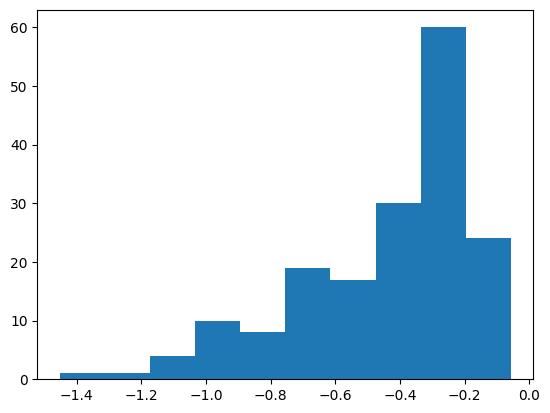

In [54]:
import matplotlib.pyplot as plt


plt.hist(scores)

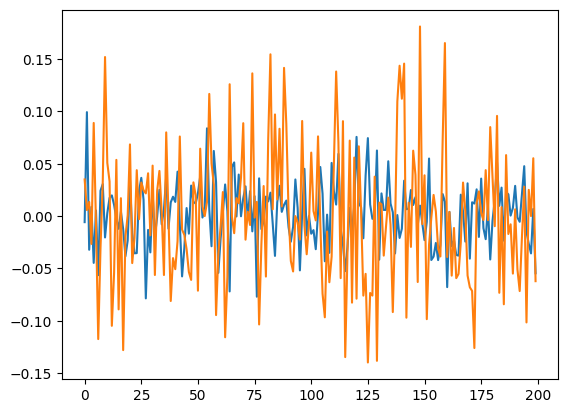

In [55]:
plt.plot(predictions[:,4])
plt.plot(y_test_movie.T[:,4])

In [40]:
regr.coef_.shape

(174, 768)